# Nekonformní funkce

Tato utilitka poukazuje na možné problematické použití nekonformních funkcí, které nejsou v jistém smyslu kompatibilní s aproximovaným prostorem. Nejprve představme tuto utilitku. Je zatím uvedena bez komentáře, postupně bude zapracována do textu.

In [7]:
import dolfinx as dfx
from mpi4py import MPI
import matplotlib.pyplot as plt
import numpy as np
import ufl
import dolfinx.fem.petsc
from petsc4py.PETSc import ScalarType


# --------------------
# Classes and methods
# --------------------
def left(x):
    return np.isclose(x[0], 0)


def right(x):
    return np.isclose(x[0], 1)


def piece_constant_solver(pos_i, qd):
    # --------------------
    # Define geometry
    # --------------------
    domain = dfx.mesh.create_unit_interval(MPI.COMM_WORLD, 2)
    tdim = domain.topology.dim
    fdim = tdim - 1

    # --------------------
    # Define spaces
    # --------------------
    V = dfx.fem.FunctionSpace(domain, ("Lagrange", 1))

    x = V.tabulate_dof_coordinates()
    x_order = np.argsort(x[:, 0])

    # --------------------
    # Boundary conditions
    # --------------------
    left_dofs = dfx.fem.locate_dofs_geometrical(V, left)
    right_dofs = dfx.fem.locate_dofs_geometrical(V, right)

    bcs = [
        dfx.fem.dirichletbc(0.0, left_dofs, V),
        dfx.fem.dirichletbc(1.0, right_dofs, V),
    ]

    # --------------------
    # Initialization
    # --------------------
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)

    # --------------------
    # Weak form
    # --------------------
    xs = ufl.SpatialCoordinate(domain)
    p = ufl.conditional(xs[0] < pos_i, 1, 0.1)
    dx_mod = ufl.Measure("dx", metadata={"quadrature_degree": qd})
    f = dfx.fem.Constant(domain, ScalarType(0.0))
    a = p*u.dx(0)*v.dx(0)*dx_mod
    L = ufl.inner(f, v)*ufl.dx

    # --------------------
    # Solution
    # --------------------
    u_sol = dfx.fem.Function(V, name="Displacement")
    problem = dfx.fem.petsc.LinearProblem(
        a, L, u=u_sol, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
    )
    problem.solve()

    # --------------------
    # Postprocess
    # --------------------
    plt.plot(x[x_order, 0], u_sol.x.array[x_order], "-", label="xi={}, qd={}".format(pos_i, qd))

Jedná se o obyčejnou úlohu vedení tepla se skokově měnícím se koeficientem tepelné vodivosti. Tedy levá část domény má materiálový parametr 1, zatímco pravá má 0.1. Síť je uvažována schválně ze dvou prvků.

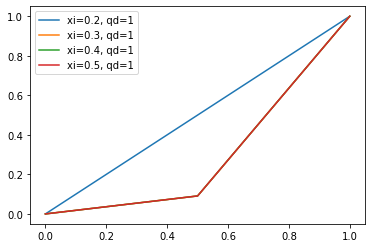

In [9]:
piece_constant_solver(0.2, 1)
piece_constant_solver(0.3, 1)
piece_constant_solver(0.4, 1)
piece_constant_solver(0.5, 1)
plt.legend()
plt.show()

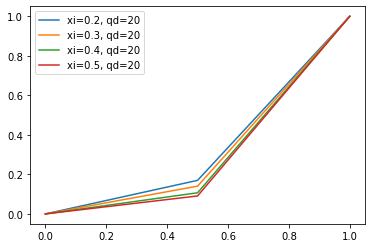

In [10]:
piece_constant_solver(0.2, 20)
piece_constant_solver(0.3, 20)
piece_constant_solver(0.4, 20)
piece_constant_solver(0.5, 20)
plt.legend()
plt.show()